In [17]:
using Random
using Plots
using LaTeXStrings

In [18]:
function set_chromosome_size!(n::Int8)
        #=
        Function that chooses one of the chromosome sizes in the menu
        Options are 8, 16, 32, 64 based on integer sizes.
        Uses Branchless programming technique with boolean logic to remove edge cases
        in:
                n: a number between (incl.) 1 and 5
        out:
                an integer representing the size of the chromosome integer in bits
        =# 
        options = [8, 16, 32, 64]
        is_within_boundaries = (n <= length(options) && n > 0)
        position = is_within_boundaries * n +
                    1 * !(is_within_boundaries)
        return options[position]
end

set_chromosome_size! (generic function with 1 method)

Now we will make functions which will create integers that will act as chromosomes for the knapsack problem

In [19]:
function create_chromosome()
        #=
        Creates a integer that will act as a chromosome with the size of 64 bits
                or 64 'genes', though some of these genes can be turned off with the
                settings given in the set_chromosome_size!() function.
        in:
                nothing
        out:
                a 64-bit integer representing a chromosome

        =# 
        return rand(Int64)::Int64
end

create_chromosome (generic function with 1 method)

In [20]:
function create_item_list(chromosome_size::Int)
        #=
        Creates a item list with the values and the weights (separately) based on the chromosome size
        A maximum value is decided which decides the max weight and value any item can hold

        in:
                chromosome_size -> the size of a chromsome
        out:
                values -> a list of values containing the value of any given item
                weights -> a list of weights containing the weight of any given item
        =# 
        max_value = 200
        values::Vector{Int64} = rand((1:max_value), chromosome_size)
        weights::Vector{Int64} = rand((1:max_value), chromosome_size)
        return values, weights
end

create_item_list (generic function with 1 method)

In [21]:
function calculate_fitness(chromosome::Int64, 
                           chromosome_size::Int8,
                           values::Vector{Int64},
                           weights::Vector{Int64},
                           max_weight::Int64)
        #=
        Calculates the fitness of any given individual's chromosome
        With the weights and values given in the dataset.
        When the weight is over the maximum weight however, the fitness will be zero

        in:
                chromosome: a chromosome containing the building blocks
                chromosome_size: the size of the chromosome
                values: the different values all of the knapsack items have
                weights: the different weights all of the knapsack items have
                max_weight: the maximum weight a knapsack is able to hold
        out:
                the fitness (and value) the knapsack-chromosome has.
        =# 
        weight = 0
        value = 0
        for n = 1:chromosome_size
                # a binary way of finding whether any given
                # bit is not zero
                n_bit = (chromosome & (1 << n) != 0)
                weight += n_bit * weights[n]
                value += n_bit * values[n]
        end
        return (weight < max_weight) * value
end

calculate_fitness (generic function with 1 method)

In [22]:
function recombine_chromosomes!(chromosome_a::Int64,
                                chromosome_b::Int64,
                                chromosome_size::Int8,
                                mutation_chance::Float32)
        #=
        Creates new recombinants of the two chromosomes provided
        Also mutates a single chromosome based on the mutation chanced provided.
        in:
                2 chromosomes:  a and b.
                chromosome_size: a size (in bits) of a chromosome
                mutation_chance: the chance of a mutation occurring in any gene within the chromosome
        out:
                2 recombinant chromosomes. based on the two parents a and b and the mutations.
        =# 
        chromatid_length = chromosome_size >> 1
        offset = 64 - chromatid_length

        chromatid1 = (chromosome_a << offset) >>> offset
        chromatid2 = (chromosome_a >>> chromatid_length) << chromatid_length
        
        
        chromatid3 = (chromosome_b << offset) >>> offset
        chromatid4 = (chromosome_b >>> chromatid_length) << chromatid_length
        
        new_chromosome1::Int64 = chromatid1 + chromatid4
        new_chromosome2::Int64 = chromatid2 + chromatid3

        mutant1 = (rand() < (mutation_chance / 2)) * rand(1:chromosome_size)
        mutant2 = (rand() < (mutation_chance / 2)) * rand(1:chromosome_size)

        
        new_chromosome1 = new_chromosome1 ⊻ (1 << mutant1)
        new_chromosome2 = new_chromosome2 ⊻ (1 << mutant2)


        return new_chromosome1, new_chromosome2
end

recombine_chromosomes! (generic function with 1 method)

In [23]:
function create_starting_population(population_size::Int, chromosome_size::Int8)
        #=
        Function that creates a starting population 
                and sets a few settings to start the evolutionary algorithm
        =#
        chromosome_size = set_chromosome_size!(chromosome_size)
        population = [create_chromosome() for i in 1:population_size]
        values, weights = create_item_list(chromosome_size)
        return chromosome_size, population, values, weights
end

create_starting_population (generic function with 1 method)

In [24]:
function find_top_n(fitness_scores::Vector{Int}, n::Int)
        #=
        Finds the n unique top values in a vector with their respective indices
        =# 
        top_n = [maximum(fitness_scores)]
        top_n_indices = [indexin(maximum(fitness_scores), fitness_scores)[1]]
        for i in 1:(n-1)
                append!(top_n, 0)
                append!(top_n_indices, 1)
                for j in enumerate(fitness_scores)
                        d = j[1]
                        s = j[2]
                        condition1 = (top_n[end] < s && s < top_n[end - 1])
                        condition2 = (top_n[end] >= s || s >= top_n[end - 1])

                        top_n[end] = condition1 * s + condition2 * top_n[end]
                        top_n_indices[end] = condition1 * d + condition2 * top_n_indices[end]
                end
        end
        return top_n, top_n_indices
end


find_top_n (generic function with 1 method)

In [25]:
function start_file(values, weights, max_weight, mutation_chance, generations)
        #=
        Writes a tsv-file for the generations and their performance
        and a settings file with all the data before running the program.
        =#
        infile = open("generations.tsv", "w")
        write(infile, "generation\thighest_fitness\tweight\tchromosome\n")

        infile2 = open("generation_values_weights.txt", "w")
        write(infile2, "values: $values\nweights: $weights\nmax weight: $max_weight\nmutation_chance: $mutation_chance\ngenerations: $generations\n")
        close(infile2)

        return infile
end

start_file (generic function with 1 method)

In [26]:
function writeLine(infile, generation, highest_fitness, weight, chromosome)
        #=
        Writes a line in the infile file. In the form of a .tsv-file
        =#
        write(infile, "$generation\t$highest_fitness\t$weight\t$chromosome\n")
end

writeLine (generic function with 1 method)

In [27]:
function calculate_weight(chromosome::Int64, 
                          chromosome_size::Int8,
                          values::Vector{Int64},
                          weights::Vector{Int64},
                          max_weight::Int64)
        #=
        Calculates the total weight of a chromosome
        IT DOES NOT CHECK WHETHER IT EXCEEDS THE MAXIMUM WEIGHT
        =#
        weight = 0
        for n = 1:chromosome_size
                # a binary way of finding whether any given
                # bit is not zero
                n_bit = (chromosome & (1 << n) != 0)
                weight += n_bit * weights[n]
        end
        return weight
end

calculate_weight (generic function with 1 method)

In [28]:
function main()
        chromosome_size::Int8 = 4
        population_size = 30
        chromosome_size, population, values, weights = create_starting_population(population_size, chromosome_size)
        max_weight = 2500
        generations = 1250
        mutation_chance::Float32 = 0.03
        top_performers = []

        infile = start_file(values, weights, max_weight, mutation_chance, generations)

        for i = 1:generations
                fitness_scores = population .|> x -> calculate_fitness(x, chromosome_size, values, weights, max_weight)
                top_performers, top_performers_indices = find_top_n(fitness_scores, 4)
                # println(top_performers)
                # println(population)
                new_population = []
                for _ in 1:population_size
                        append!(new_population, recombine_chromosomes!(population[rand(top_performers_indices)],
                                                                       population[rand(top_performers_indices)],
                                                                       chromosome_size,
                                                                       mutation_chance))
                end
                top_weight = calculate_weight(population[top_performers_indices[1]],
                                              chromosome_size,
                                              values,
                                              weights,
                                              max_weight)
        
                writeLine(infile, i, top_performers[1], top_weight, bitstring(population[top_performers_indices[1]]))
                population = copy(new_population)
                
        end
        close(infile)
end


main (generic function with 1 method)

In [32]:
@time main()

  0.014795 seconds (261.44 k allocations: 11.307 MiB)


In [14]:
function read_file()
        #=
        Reads the generation.tsv file
        =#
        infile = open("generations.tsv", "r")
        raw = readlines(infile)
        close(infile)
        return raw
end

read_file (generic function with 1 method)

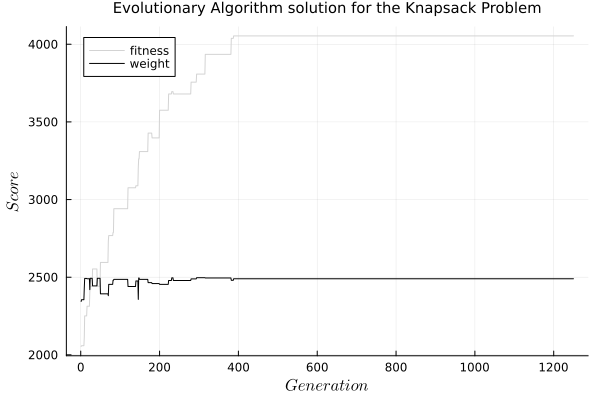

In [15]:
function plotData()
        raw = read_file()
        data = [split(line, "\t") for line in raw]
        headers = data[1]
        data = [[parse(Int, num) for num in line[begin:end - 1]] for line in data[2:end]]
        
        generation = [i[1] for i in data]
        fitness = [i[2] for i in data]
        weight = [i[3] for i in data]

        plot(
                generation,
                fitness,
                label = "fitness",
                color = :lightgray,
                titlefontsize=10
        )
        plot!(
                generation,
                weight,
                label = "weight",
                color = :black
        )
        

        title!("Evolutionary Algorithm solution for the Knapsack Problem")
        xlabel!(L"Generation")
        ylabel!(L"Score")


end
plotData()